### Загрузим необходимые библиотеки

In [1]:
import pymc as pm
import arviz as az
import pandas as pd
import numpy as np
from scipy.special import expit
import xarray as xr
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import pytensor.tensor as pt
from scipy.stats import gaussian_kde

%matplotlib inline
az.style.use("arviz-white")

### Предобработаем данные

In [2]:
# data = pd.read_parquet('data R2D2.pt')
data = pd.read_parquet('R2D2 data2.pt')
agg = data.groupby(['date', 'hour']).agg({'late':'sum', 'distance':'sum', 'day':'first', 'test':'first', 'longitude': 'size', 'id_courier':'nunique'}).reset_index().rename(columns={'longitude':'parcels_quantity'}).drop(columns={'date'})

# стандартизируем дистанцию, поскольку будет мешать в последующих вычислениях
Xscaler = StandardScaler()
agg['distance'] = Xscaler.fit_transform(agg[['distance']])

# создадим дамми переменные для моделей и уберем мультиколлинеарность
df = pd.get_dummies(agg, columns=['day', 'hour'], prefix=['day', 'hour'], dtype=int, drop_first=True)

# для второй модели проще заводить в формате array
data_array = df.drop(columns={'late'}).to_numpy()
Y = df['late'].to_numpy()

### Реальный uplift

In [3]:
group0 = data[data['test'] == 0]
group1 = data[data['test'] == 1]

group0_mean = group0['late'].sum() / group0['late'].count()
group1_mean = group1['late'].sum() / group1['late'].count()

bez_slot = data[(data['slot'] == 0) | (data['slot'].isna())].copy()
bez_slot['click_to_eat'] = (pd.to_datetime(bez_slot['date_delivered']) - pd.to_datetime(bez_slot['date_posted'])).dt.total_seconds() / 60
bez_slot = bez_slot[bez_slot['click_to_eat'] < 60].copy()

group0_click = bez_slot[bez_slot['test'] == 0]
group1_click = bez_slot[bez_slot['test'] == 1]

group0_click_mean = group0_click['click_to_eat'].mean()
group1_click_mean = group1_click['click_to_eat'].mean()

print('uplift при работе adaptive в % опозданий', round(((group1_mean - group0_mean) / group0_mean * 100), 2), '%')
print('% опозданий группа с тестом', round(group1_mean * 100,2))
print('% опозданий группа без теста', round(group0_mean * 100,2))
print('uplift при работе adaptive в click-to-eat', round(((group1_click_mean - group0_click_mean) / group0_click_mean * 100), 2), '%')
print('click-to-eat группа с тестом', round(group1_click_mean,2))
print('click-to-eat группа без теста', round(group0_click_mean,2))

uplift при работе adaptive в % опозданий 24.26 %
% опозданий группа с тестом 6.13
% опозданий группа без теста 4.93
uplift при работе adaptive в click-to-eat 2.81 %
click-to-eat группа с тестом 24.98
click-to-eat группа без теста 24.29


### Иерархическая линеная модель

In [4]:
coords = {"observations": df.index}

with pm.Model(coords=coords) as model:
    pm.Data("distance", df['distance'].values, dims="observations")
    pm.Data("parcels", df['parcels_quantity'].values, dims="observations")
    pm.Data("test", df['test'].values, dims="observations")
    pm.Data("late_obs", df['late'].values, dims="observations")

    day_cols = [col for col in df if col.startswith("day_")]
    hour_cols = [col for col in df if col.startswith("hour_")]

    pm.Data("day", df[day_cols].values, dims=("observations", "day_dim"))
    pm.Data("hour", df[hour_cols].values, dims=("observations", "hour_dim"))

    alpha = pm.Normal("alpha", mu=0, sigma=5)

    beta_test = pm.Normal("beta_test", mu=0, sigma=1)
    beta_parcel = pm.Normal("beta_parcel", mu=0, sigma=1)
    beta_day = pm.Normal("beta_day", mu=0, sigma=1, dims="day_dim")
    beta_hour = pm.Normal("beta_hour", mu=0, sigma=1, dims="hour_dim")
    beta_distance = pm.Normal("beta_distance", mu=0, sigma=1)

    mu = (alpha 
          + beta_test * model["test"]
          + beta_parcel * model["parcels"]
          + pm.math.dot(model["day"], beta_day)
          + pm.math.dot(model["hour"], beta_hour)
          + beta_distance * model["distance"])

    p = pm.Deterministic("p", pm.math.sigmoid(mu), dims="observations")

    late_like = pm.Binomial("late_like", n=model["parcels"], p=p, observed=model["late_obs"], dims="observations")

In [5]:
model

        alpha ~ Normal(0, 5)
    beta_test ~ Normal(0, 1)
  beta_parcel ~ Normal(0, 1)
     beta_day ~ Normal(0, 1)
    beta_hour ~ Normal(0, 1)
beta_distance ~ Normal(0, 1)
            p ~ Deterministic(f(beta_distance, beta_hour, beta_day, beta_parcel, alpha, beta_test))
    late_like ~ Binomial(<shared>, p)

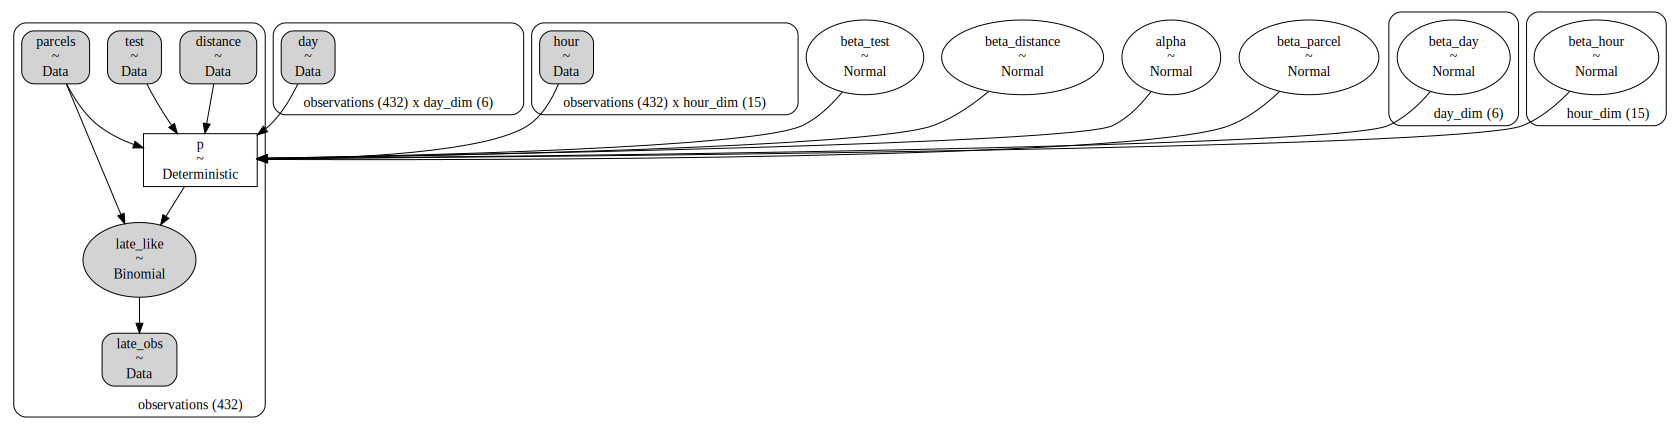

In [6]:
model.to_graphviz()

In [7]:
with model:
    prior = pm.sample_prior_predictive()

Sampling: [alpha, beta_day, beta_distance, beta_hour, beta_parcel, beta_test, late_like]


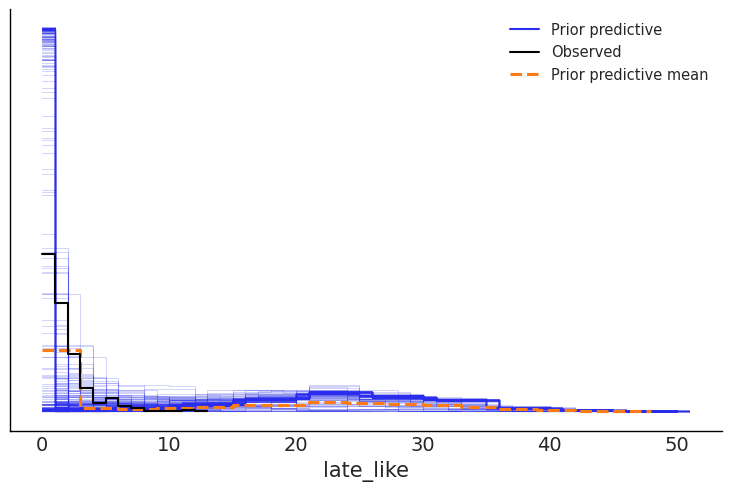

In [8]:
az.plot_ppc(prior, group="prior", observed=True)
plt.show()

In [9]:
with model:
    trace = pm.sample()
    trace.extend(prior)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_test, beta_parcel, beta_day, beta_hour, beta_distance]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


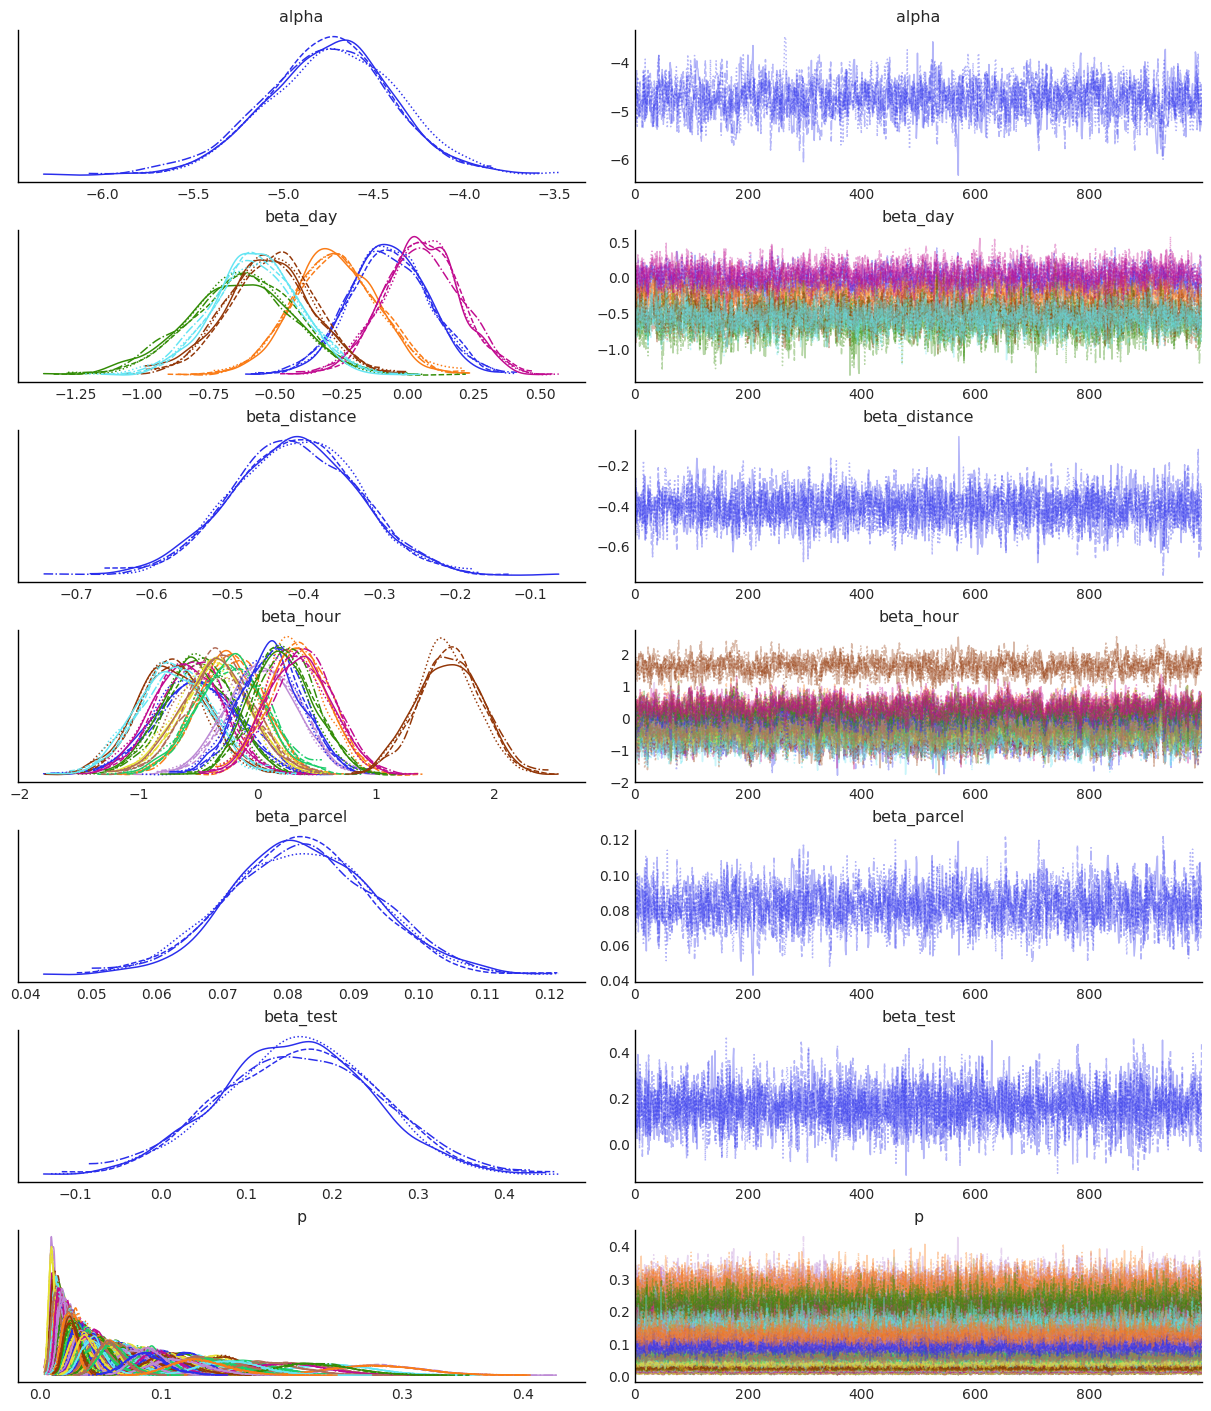

In [10]:
az.plot_trace(trace)
plt.show()

In [11]:
pm.summary(trace).sort_values('ess_bulk')

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta_hour[11]  0.338  0.254  -0.138    0.799      0.009    0.006     865.0   
beta_hour[12]  0.212  0.264  -0.287    0.700      0.009    0.006     951.0   
p[272]         0.031  0.008   0.016    0.046      0.000    0.000     963.0   
p[384]         0.037  0.010   0.020    0.055      0.000    0.000     997.0   
beta_hour[13]  0.361  0.268  -0.124    0.872      0.008    0.006    1010.0   
...              ...    ...     ...      ...        ...      ...       ...   
p[249]         0.049  0.011   0.030    0.071      0.000    0.000    6246.0   
p[297]         0.063  0.014   0.038    0.089      0.000    0.000    6359.0   
p[232]         0.056  0.013   0.033    0.079      0.000    0.000    6371.0   
p[296]         0.052  0.012   0.032    0.077      0.000    0.000    6398.0   
p[312]         0.038  0.009   0.022    0.055      0.000    0.000    6522.0   

               ess_tail  r_hat  
beta_hour[11]    1581.0   1.01  
beta_hour[12]    1757.0   1.01  
p[272]           1258.0   1.00  
p[384]           1230.0   1.00  
beta_hour[13]    1555.0   1.01  
...                 ...    ...  
p[249]           3056.0   1.00  
p[297]           3273.0   1.00  
p[232]           3228.0   1.00  
p[296]           3161.0   1.01  
p[312]           2910.0   1.00  

[457 rows x 9 columns]

In [12]:
pm.summary(trace).sort_values('ess_bulk').query('r_hat > 1.02')

Empty DataFrame
Columns: [mean, sd, hdi_3%, hdi_97%, mcse_mean, mcse_sd, ess_bulk, ess_tail, r_hat]
Index: []

In [13]:
az.summary(trace, var_names=["beta_test"])

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta_test  0.161  0.09  -0.018     0.32      0.001    0.001    3875.0   

           ess_tail  r_hat  
beta_test    2698.0    1.0

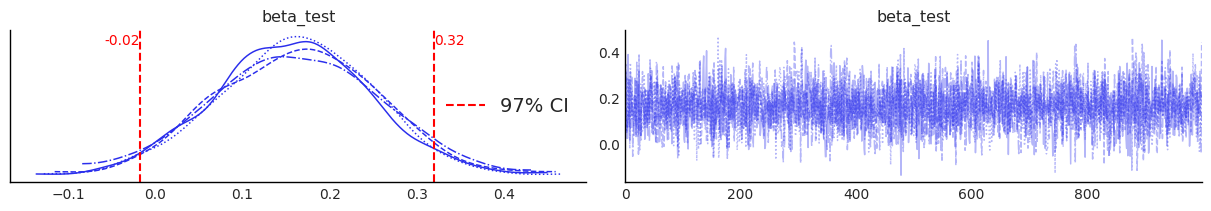

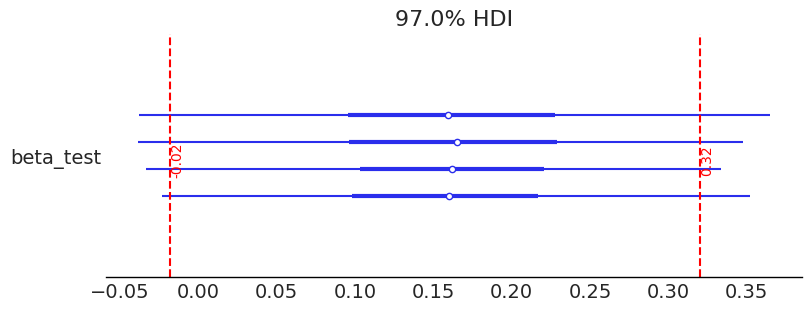

In [37]:
summary = az.summary(trace, var_names=["beta_test"])
ci_lower = summary.loc["beta_test", "hdi_3%"]
ci_upper = summary.loc["beta_test", "hdi_97%"]

axes = az.plot_trace(trace, var_names=["beta_test"])

dist_ax, trace_ax = axes[0] 

dist_ax.axvline(ci_lower, color="red", linestyle="--", label="97% CI")
dist_ax.axvline(ci_upper, color="red", linestyle="--")
y_min, y_max = dist_ax.get_ylim()
dist_ax.text(ci_lower, y_max * 0.9, f"{ci_lower:.2f}", color="red", ha="right")
dist_ax.text(ci_upper, y_max * 0.9, f"{ci_upper:.2f}", color="red", ha="left")
dist_ax.legend()

plt.show()

fig, ax = plt.subplots(figsize=(8, 3))
az.plot_forest(trace, var_names=["beta_test"], combined=False, ax=ax, hdi_prob=0.97)

ax.axvline(ci_lower, color="red", linestyle="--")
ax.axvline(ci_upper, color="red", linestyle="--")
ax.text(ci_lower, 0.2, f"{ci_lower:.2f}", color="red", rotation=90, verticalalignment="center")
ax.text(ci_upper, 0.2, f"{ci_upper:.2f}", color="red", rotation=90, verticalalignment="center")

plt.show()

### R2D2 non-centered модель

In [15]:
data_array = df.drop(columns={'late', 'id_courier'}).to_numpy()
Y = df['late'].to_numpy()

In [16]:
#### Хорошая модель!!!!!!!

data_array = df.drop(columns={'late', 'id_courier'}).to_numpy()
Y = df['late'].to_numpy()

data_array_std = data_array.copy()

for col in [2, 3]:
    col_mean = data_array[:, col].mean()
    col_std = data_array[:, col].std()
    data_array_std[:, col] = (data_array[:, col] - col_mean) / col_std

coords = {
    "obs": df.index,
    "variable": ["distance", "test", "parcels_quantity"
                 ,"day_1", "day_2", "day_3", "day_4", "day_5", "day_6", "hour_8", "hour_9", "hour_10", "hour_11", "hour_12", "hour_13", "hour_14", "hour_15", "hour_16", "hour_17", "hour_18", "hour_19", "hour_20", "hour_21", "hour_22"]
}


with pm.Model(coords=coords) as model2:
    r2 = pm.Beta("r2", mu=0.5, sigma=0.2)
    total_variance = pm.HalfNormal("total_variance", sigma=1.0)
    intercept = pm.Normal('intercept', mu=-3, sigma=1)

    eps = pm.Deterministic('eps', pm.math.sqrt(total_variance * (1 - r2)))
    model_std = pm.Deterministic('model_std', pm.math.sqrt(total_variance * r2))

    importances = pm.Data("importance", [5] * len(coords["variable"]), dims='variable')
    fraction_var_explained = pm.Dirichlet("fraction_var_explained", importances, dims="variable")

    beta_std = pm.Deterministic('beta_std', model_std * pm.math.sqrt(fraction_var_explained), dims='variable')
    beta_raw = pm.Normal('beta_raw', mu=0, sigma=1, dims='variable')
    beta = pm.Deterministic('beta', beta_raw * beta_std, dims='variable')

    XN_tensor = pm.Data('XN', data_array_std, dims=('obs', 'variable'))
    mu = intercept + pm.math.dot(XN_tensor, beta)

    parcels_quantity = pt.cast(data_array[:, 2], 'int64')

    p = pm.Deterministic("p", pm.math.sigmoid(mu), dims="obs")

    phi_unclipped = 1.0 / (eps**2 + 1e-3)
    phi = pm.Deterministic("phi", pm.math.minimum(phi_unclipped, 1e3))

    late_like = pm.BetaBinomial("late_like",
                                n=parcels_quantity,
                                alpha=p * phi,
                                beta=(1 - p) * phi,
                                observed=Y,
                                dims="obs")


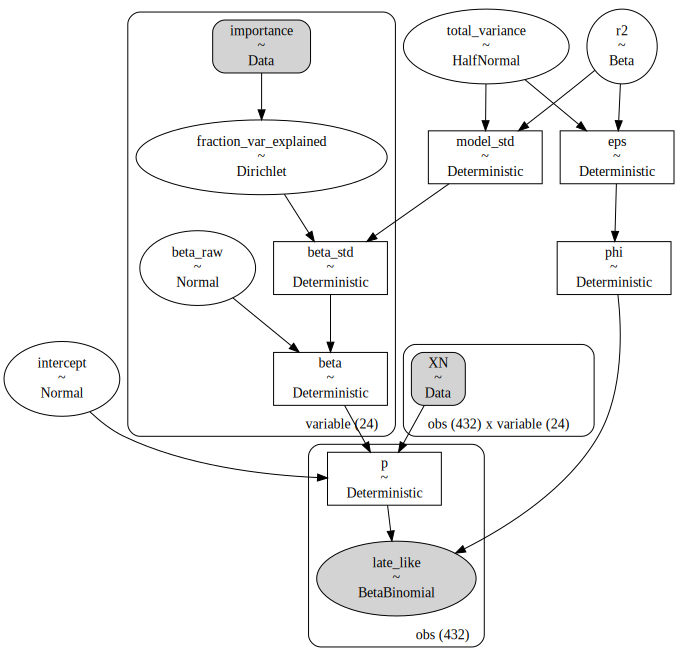

In [17]:
model2.to_graphviz()

/home/epicyaraa/.local/lib/python3.10/site-packages/pytensor/link/c/cmodule.py:2959: UserWarning: PyTensor could not link to a BLAS installation. Operations that might benefit from BLAS will be severely degraded.
This usually happens when PyTensor is installed via pip. We recommend it be installed via conda/mamba/pixi instead.
Alternatively, you can use an experimental backend such as Numba or JAX that perform their own BLAS optimizations, by setting `pytensor.config.mode == 'NUMBA'` or passing `mode='NUMBA'` when compiling a PyTensor function.
For more options and details see https://pytensor.readthedocs.io/en/latest/troubleshooting.html#how-do-i-configure-test-my-blas-library
  warnings.warn(
Sampling: [beta_raw, fraction_var_explained, intercept, late_like, r2, total_variance]


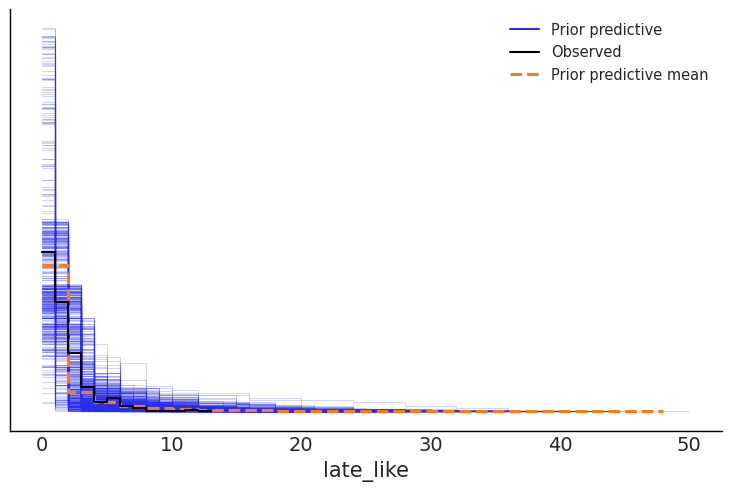

In [18]:
with model2:
    prior2 = pm.sample_prior_predictive()

az.plot_ppc(prior2, group="prior", observed=True)
plt.show()

In [19]:
with model2:
    trace2 = pm.sample()
    trace2.extend(prior2)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [r2, total_variance, intercept, fraction_var_explained, beta_raw]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 34 seconds.


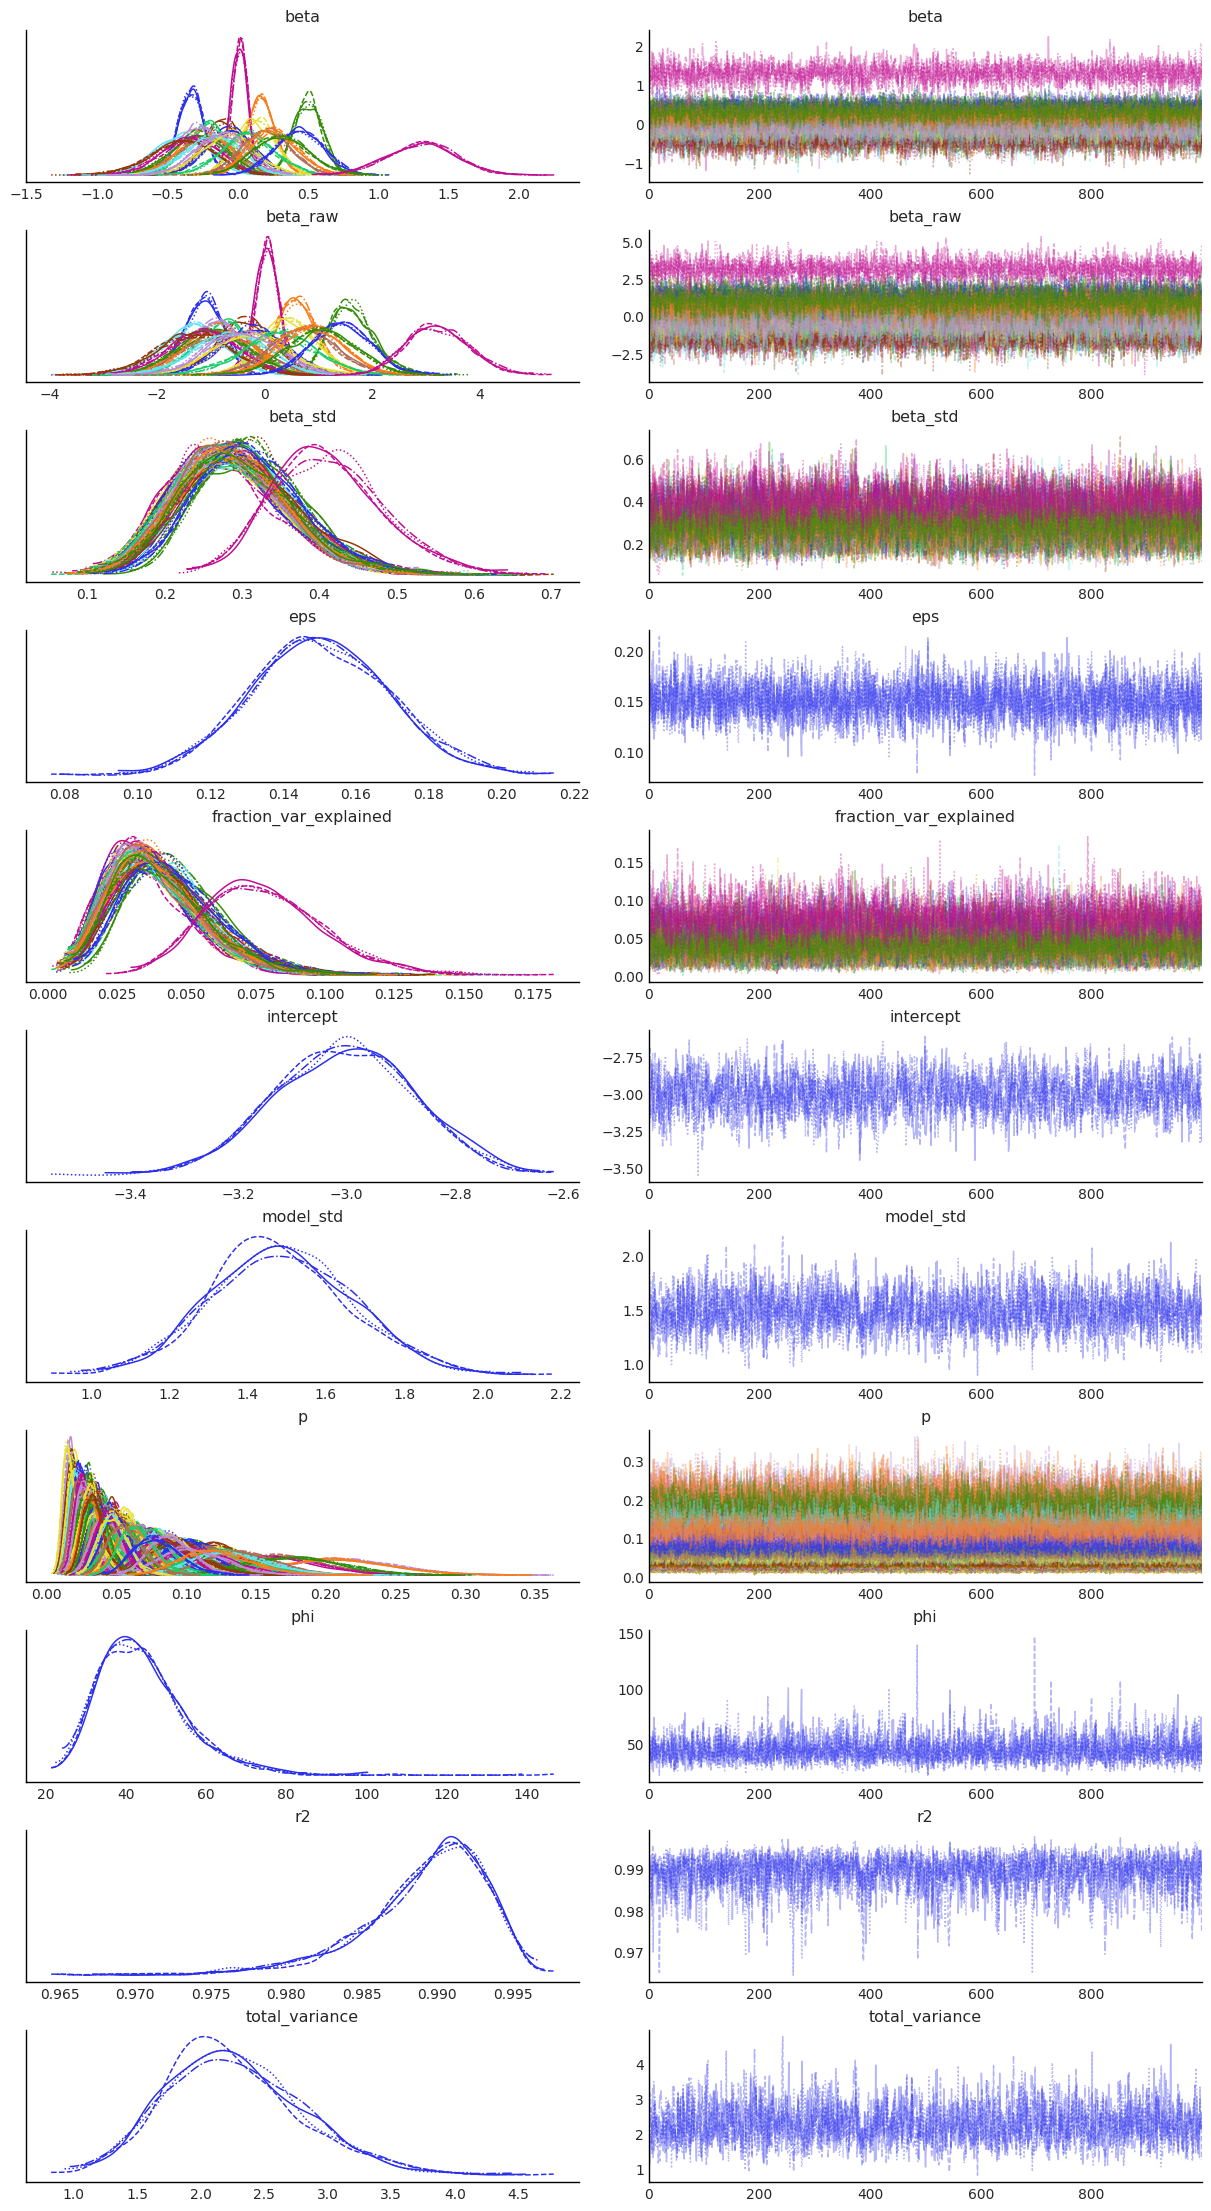

In [20]:
az.plot_trace(trace2)
plt.show()

<Axes: title={'center': 'r2'}>

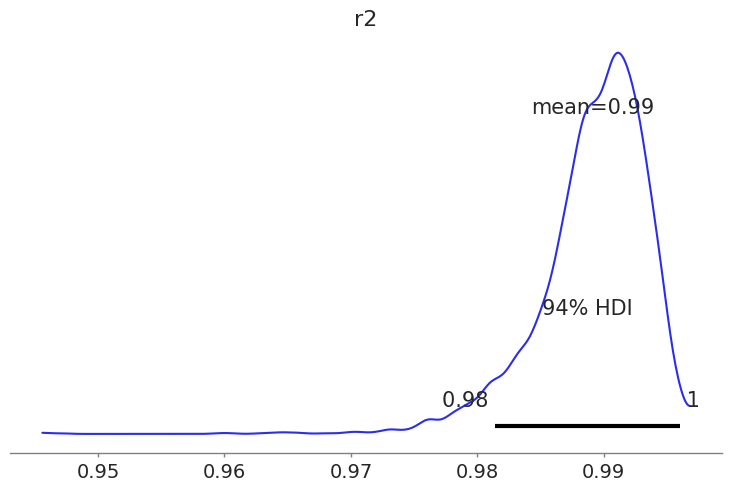

In [141]:
az.plot_posterior(trace2, var_names=['r2'])

In [31]:
summary_df = pm.summary(trace2, var_names=['beta'], coords={'variable': ['test']}).sort_values('ess_bulk')
print(summary_df)

             mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta[test]  0.166  0.099  -0.022    0.355      0.001    0.001    4675.0   

            ess_tail  r_hat  
beta[test]    3178.0    1.0  


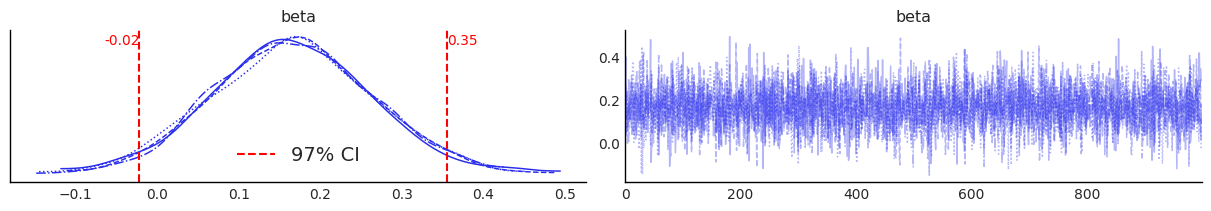

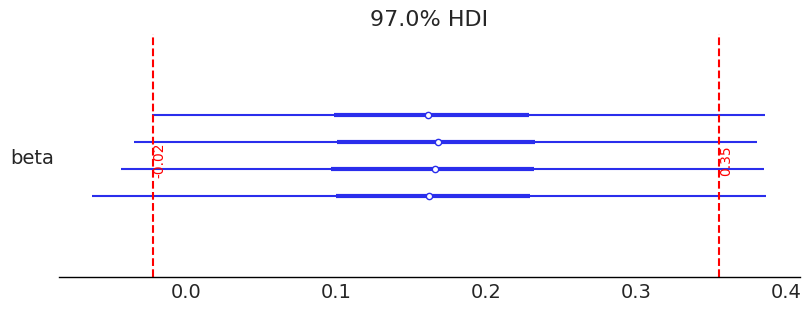

In [38]:
summary = az.summary(trace2, var_names=['beta'], coords={'variable': ['test']})
ci_lower = summary.loc["beta[test]", "hdi_3%"]
ci_upper = summary.loc["beta[test]", "hdi_97%"]

axes = az.plot_trace(trace2, var_names=['beta'], coords={'variable': ['test']})

dist_ax, trace_ax = axes[0] 

dist_ax.axvline(ci_lower, color="red", linestyle="--", label="97% CI")
dist_ax.axvline(ci_upper, color="red", linestyle="--")
y_min, y_max = dist_ax.get_ylim()
dist_ax.text(ci_lower, y_max * 0.9, f"{ci_lower:.2f}", color="red", ha="right")
dist_ax.text(ci_upper, y_max * 0.9, f"{ci_upper:.2f}", color="red", ha="left")
dist_ax.legend()

plt.show()

fig, ax = plt.subplots(figsize=(8, 3))
az.plot_forest(trace2, var_names=['beta'], coords={'variable': ['test']}, combined=False, ax=ax, hdi_prob=0.97)

ax.axvline(ci_lower, color="red", linestyle="--")
ax.axvline(ci_upper, color="red", linestyle="--")
ax.text(ci_lower, 0.2, f"{ci_lower:.2f}", color="red", rotation=90, verticalalignment="center")
ax.text(ci_upper, 0.2, f"{ci_upper:.2f}", color="red", rotation=90, verticalalignment="center")

plt.show()

### Посмотрим также на курьерскую утилизацию

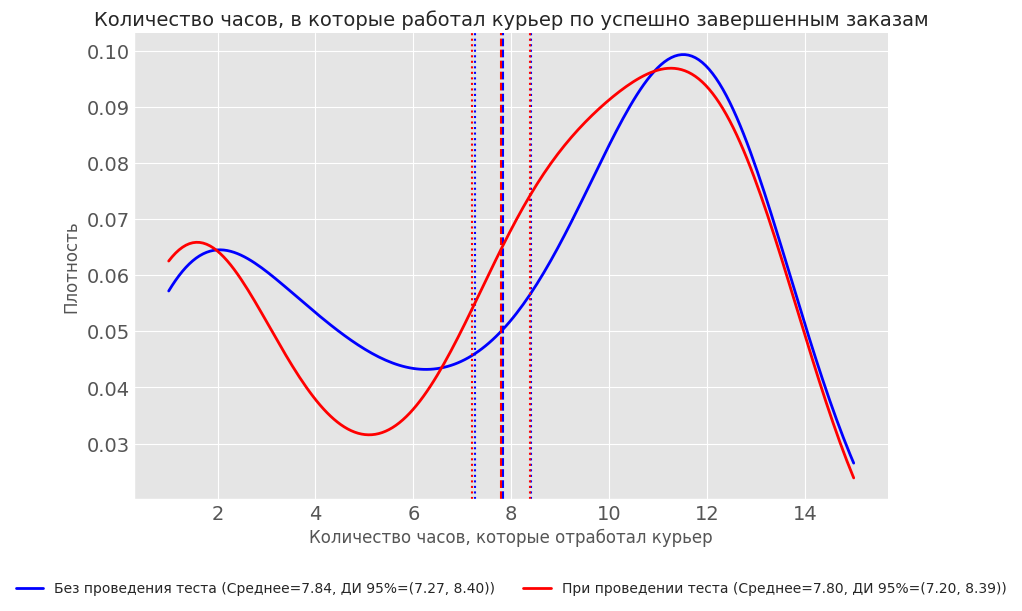

uplift по количеству отработанных часов -0.52 %


In [149]:
plt.style.use('ggplot')

group0 = data[data['test'] == 0].groupby(['date', 'id_courier'])['hour'].nunique().reset_index()['hour']
group1 = data[data['test'] == 1].groupby(['date', 'id_courier'])['hour'].nunique().reset_index()['hour']

mean0 = group0.mean()
se0 = group0.std() / np.sqrt(len(group0))
ci0_lower = mean0 - 1.96 * se0
ci0_upper = mean0 + 1.96 * se0

mean1 = group1.mean()
se1 = group1.std() / np.sqrt(len(group1))
ci1_lower = mean1 - 1.96 * se1
ci1_upper = mean1 + 1.96 * se1

x_min = min(group0.min(), group1.min())
x_max = max(group0.max(), group1.max())
x_grid = np.linspace(x_min, x_max, 200)

kde0 = gaussian_kde(group0)
kde1 = gaussian_kde(group1)
y0 = kde0(x_grid)
y1 = kde1(x_grid)

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(x_grid, y0, label=f"Без проведения теста (Среднее={mean0:.2f}, ДИ 95%=({ci0_lower:.2f}, {ci0_upper:.2f}))",
        linewidth=2, color='blue')
ax.axvline(mean0, color='blue', linestyle='--', linewidth=1.5)
ax.axvline(ci0_lower, color='blue', linestyle=':', linewidth=1.5)
ax.axvline(ci0_upper, color='blue', linestyle=':', linewidth=1.5)

ax.plot(x_grid, y1, label=f"При проведении теста (Среднее={mean1:.2f}, ДИ 95%=({ci1_lower:.2f}, {ci1_upper:.2f}))",
        linewidth=2, color='red')
ax.axvline(mean1, color='red', linestyle='--', linewidth=1.5)
ax.axvline(ci1_lower, color='red', linestyle=':', linewidth=1.5)
ax.axvline(ci1_upper, color='red', linestyle=':', linewidth=1.5)

ax.set_xlabel("Количество часов, которые отработал курьер", fontsize=12)
ax.set_ylabel("Плотность", fontsize=12)
ax.set_title("Количество часов, в которые работал курьер по успешно завершенным заказам", fontsize=14)
ax.grid(True)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, fontsize=10)

plt.show()
print('uplift по количеству отработанных часов', round(((mean1 - mean0) / mean0 * 100), 2), '%')

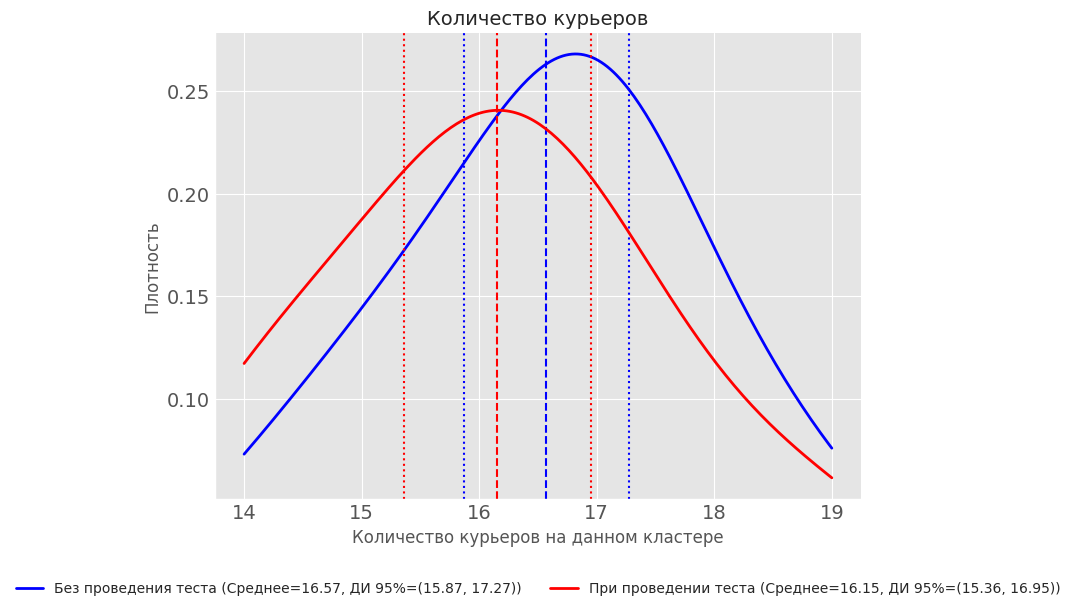

uplift по количеству курьеров -2.52 %


In [150]:
plt.style.use('ggplot')

group0 = data[data['test'] == 0].groupby(['date'])['id_courier'].nunique().reset_index()['id_courier']
group1 = data[data['test'] == 1].groupby(['date'])['id_courier'].nunique().reset_index()['id_courier']

mean0 = group0.mean()
se0 = group0.std() / np.sqrt(len(group0))
ci0_lower = mean0 - 1.96 * se0
ci0_upper = mean0 + 1.96 * se0

mean1 = group1.mean()
se1 = group1.std() / np.sqrt(len(group1))
ci1_lower = mean1 - 1.96 * se1
ci1_upper = mean1 + 1.96 * se1

x_min = min(group0.min(), group1.min())
x_max = max(group0.max(), group1.max())
x_grid = np.linspace(x_min, x_max, 200)

kde0 = gaussian_kde(group0)
kde1 = gaussian_kde(group1)
y0 = kde0(x_grid)
y1 = kde1(x_grid)

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(x_grid, y0, label=f"Без проведения теста (Среднее={mean0:.2f}, ДИ 95%=({ci0_lower:.2f}, {ci0_upper:.2f}))",
        linewidth=2, color='blue')
ax.axvline(mean0, color='blue', linestyle='--', linewidth=1.5)
ax.axvline(ci0_lower, color='blue', linestyle=':', linewidth=1.5)
ax.axvline(ci0_upper, color='blue', linestyle=':', linewidth=1.5)

ax.plot(x_grid, y1, label=f"При проведении теста (Среднее={mean1:.2f}, ДИ 95%=({ci1_lower:.2f}, {ci1_upper:.2f}))",
        linewidth=2, color='red')
ax.axvline(mean1, color='red', linestyle='--', linewidth=1.5)
ax.axvline(ci1_lower, color='red', linestyle=':', linewidth=1.5)
ax.axvline(ci1_upper, color='red', linestyle=':', linewidth=1.5)

ax.set_xlabel("Количество курьеров на данном кластере", fontsize=12)
ax.set_ylabel("Плотность", fontsize=12)
ax.set_title("Количество курьеров", fontsize=14)
ax.grid(True)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, fontsize=10)

plt.show()
print('uplift по количеству курьеров', round(((mean1 - mean0) / mean0 * 100), 2), '%')

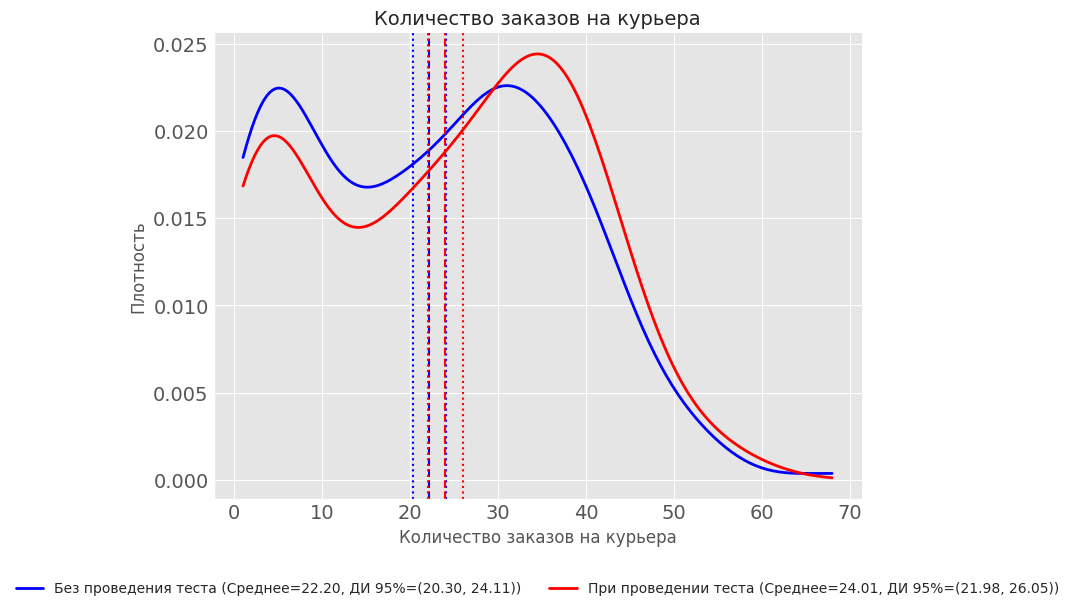

uplift по количеству заказов на курьера 8.16 %


In [151]:
plt.style.use('ggplot')

group0 = data[data['test'] == 0].groupby(['date', 'id_courier'])['date_delivered'].size().reset_index()['date_delivered']
group1 = data[data['test'] == 1].groupby(['date', 'id_courier'])['date_delivered'].size().reset_index()['date_delivered']

mean0 = group0.mean()
se0 = group0.std() / np.sqrt(len(group0))
ci0_lower = mean0 - 1.96 * se0
ci0_upper = mean0 + 1.96 * se0

mean1 = group1.mean()
se1 = group1.std() / np.sqrt(len(group1))
ci1_lower = mean1 - 1.96 * se1
ci1_upper = mean1 + 1.96 * se1

x_min = min(group0.min(), group1.min())
x_max = max(group0.max(), group1.max())
x_grid = np.linspace(x_min, x_max, 200)

kde0 = gaussian_kde(group0)
kde1 = gaussian_kde(group1)
y0 = kde0(x_grid)
y1 = kde1(x_grid)

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(x_grid, y0, label=f"Без проведения теста (Среднее={mean0:.2f}, ДИ 95%=({ci0_lower:.2f}, {ci0_upper:.2f}))",
        linewidth=2, color='blue')
ax.axvline(mean0, color='blue', linestyle='--', linewidth=1.5)
ax.axvline(ci0_lower, color='blue', linestyle=':', linewidth=1.5)
ax.axvline(ci0_upper, color='blue', linestyle=':', linewidth=1.5)

ax.plot(x_grid, y1, label=f"При проведении теста (Среднее={mean1:.2f}, ДИ 95%=({ci1_lower:.2f}, {ci1_upper:.2f}))",
        linewidth=2, color='red')
ax.axvline(mean1, color='red', linestyle='--', linewidth=1.5)
ax.axvline(ci1_lower, color='red', linestyle=':', linewidth=1.5)
ax.axvline(ci1_upper, color='red', linestyle=':', linewidth=1.5)

ax.set_xlabel("Количество заказов на курьера", fontsize=12)
ax.set_ylabel("Плотность", fontsize=12)
ax.set_title("Количество заказов на курьера", fontsize=14)
ax.grid(True)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, fontsize=10)

plt.show()
print('uplift по количеству заказов на курьера', round(((mean1 - mean0) / mean0 * 100), 2), '%')

### Учтем в моделях снижение утилизации и оценим изменение в click-to-eat и в проценте опозданий с новыми вводными

In [40]:
data_array = df.drop(columns={'late'}).to_numpy()
Y = df['late'].to_numpy()

data_array_std = data_array.copy()

for col in [2, 3]:
    col_mean = data_array[:, col].mean()
    col_std = data_array[:, col].std()
    data_array_std[:, col] = (data_array[:, col] - col_mean) / col_std

coords = {
    "obs": df.index,
    "variable": ["distance", "test", "parcels_quantity", "courier_quantity", 
                 "day_1", "day_2", "day_3", "day_4", "day_5", "day_6", 
                 "hour_8",
                 "hour_9", "hour_10", "hour_11", "hour_12", "hour_13", 
                 "hour_14", "hour_15", "hour_16", "hour_17", "hour_18", 
                 "hour_19", "hour_20", "hour_21", "hour_22"]
}

with pm.Model(coords=coords) as model3:
    r2 = pm.Beta("r2", mu=0.5, sigma=0.2)
    total_variance = pm.HalfNormal("total_variance", sigma=1.0)
    intercept = pm.Normal('intercept', mu=-3, sigma=1)

    eps = pm.Deterministic('eps', pm.math.sqrt(total_variance * (1 - r2)))
    model_std = pm.Deterministic('model_std', pm.math.sqrt(total_variance * r2))

    importances = pm.Data("importance", [5] * 25, dims='variable')
    fraction_var_explained = pm.Dirichlet("fraction_var_explained", importances, dims="variable")

    beta_std = pm.Deterministic('beta_std', model_std * pm.math.sqrt(fraction_var_explained), dims='variable')
    beta_raw = pm.Normal('beta_raw', mu=0, sigma=1, dims='variable')
    beta = pm.Deterministic('beta', beta_raw * beta_std, dims='variable')

    XN_tensor = pm.Data('XN', data_array_std, dims=('obs', 'variable'))
    mu = intercept + pm.math.dot(XN_tensor, beta)
    
    parcels_quantity = pt.cast(data_array[:, 2], 'int64')
    
    p = pm.Deterministic("p", pm.math.sigmoid(mu), dims="obs")

    phi_unclipped = 1.0 / (eps**2 + 1e-3)
    phi = pm.Deterministic("phi", pm.math.minimum(phi_unclipped, 1e3))

    late_like = pm.BetaBinomial("late_like",
                                n=parcels_quantity,
                                alpha=p * phi,
                                beta=(1 - p) * phi,
                                observed=Y,
                                dims="obs")


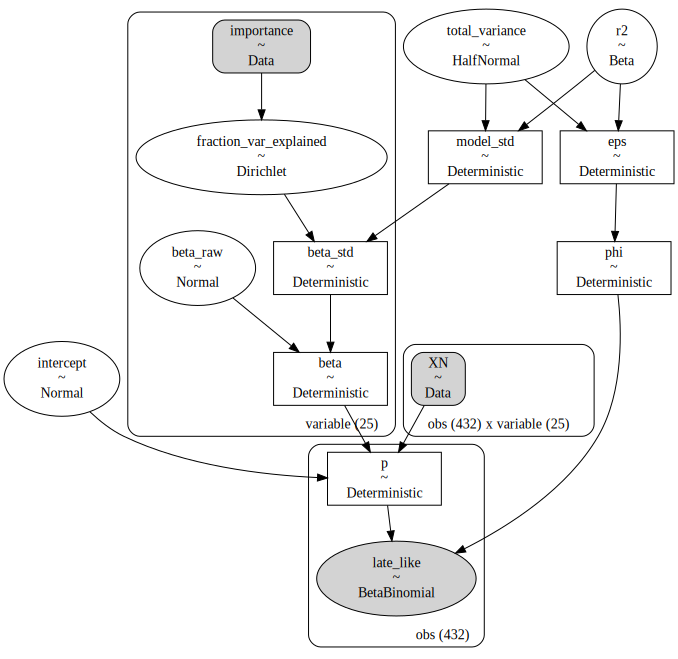

In [41]:
model3.to_graphviz()

In [42]:
with model3:
    prior3 = pm.sample_prior_predictive()

Sampling: [beta_raw, fraction_var_explained, intercept, late_like, r2, total_variance]


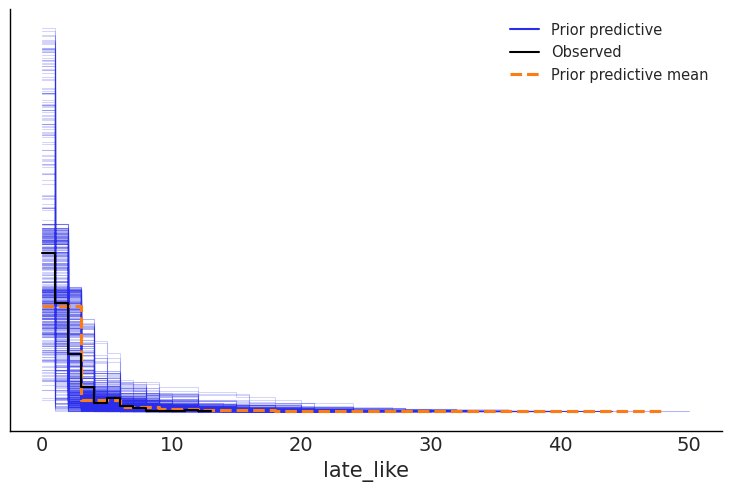

In [43]:
az.plot_ppc(prior3, group="prior", observed=True)
plt.show()

In [44]:
with model3:
    trace3 = pm.sample()
    trace3.extend(prior2)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [r2, total_variance, intercept, fraction_var_explained, beta_raw]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.


<Axes: title={'center': 'r2'}>

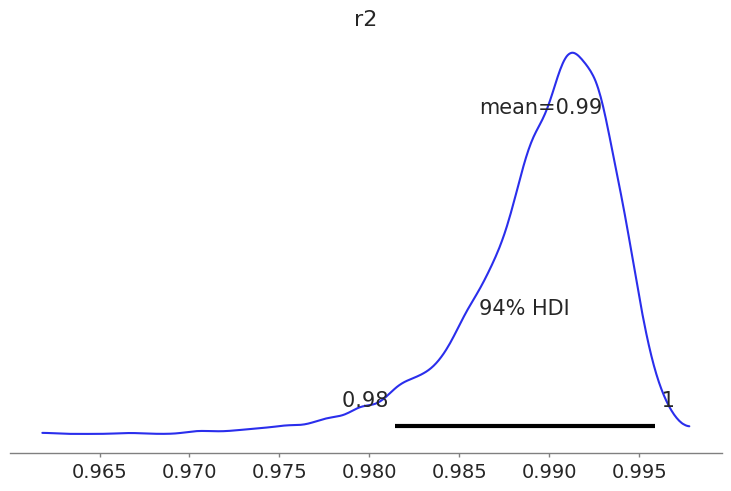

In [45]:
az.plot_posterior(trace3, var_names=['r2'])

In [46]:
summary_df = pm.summary(trace3, var_names=['beta'], coords={'variable': ['test']}).sort_values('ess_bulk')
print(summary_df)


             mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta[test]  0.115  0.102  -0.075    0.305      0.001    0.001    4829.0   

            ess_tail  r_hat  
beta[test]    2984.0    1.0  


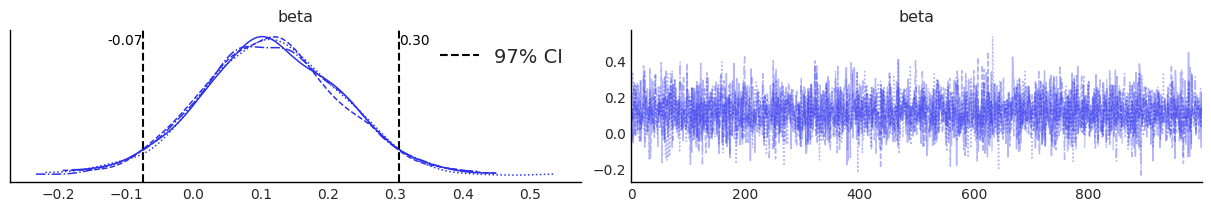

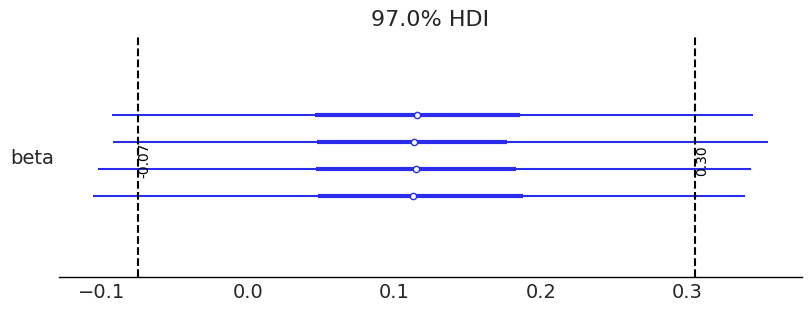

In [48]:
summary = az.summary(trace3, var_names=['beta'], coords={'variable': ['test']})
ci_lower = summary.loc["beta[test]", "hdi_3%"]
ci_upper = summary.loc["beta[test]", "hdi_97%"]

axes = az.plot_trace(trace3, var_names=['beta'], coords={'variable': ['test']})

dist_ax, trace_ax = axes[0] 

dist_ax.axvline(ci_lower, color="black", linestyle="--", label="97% CI")
dist_ax.axvline(ci_upper, color="black", linestyle="--")
y_min, y_max = dist_ax.get_ylim()
dist_ax.text(ci_lower, y_max * 0.9, f"{ci_lower:.2f}", color="black", ha="right")
dist_ax.text(ci_upper, y_max * 0.9, f"{ci_upper:.2f}", color="black", ha="left")
dist_ax.legend()

plt.show()

fig, ax = plt.subplots(figsize=(8, 3))
az.plot_forest(trace3, var_names=['beta'], coords={'variable': ['test']}, combined=False, ax=ax, hdi_prob=0.97)

ax.axvline(ci_lower, color="black", linestyle="--")
ax.axvline(ci_upper, color="black", linestyle="--")
ax.text(ci_lower, 0.2, f"{ci_lower:.2f}", color="black", rotation=90, verticalalignment="center")
ax.text(ci_upper, 0.2, f"{ci_upper:.2f}", color="black", rotation=90, verticalalignment="center")

plt.show()

### Оценим click-to-eat

In [24]:
bez_slot = data[(data['slot'] == 0) | (data['slot'].isna())].copy()
bez_slot['click_to_eat'] = (pd.to_datetime(bez_slot['date_delivered']) - pd.to_datetime(bez_slot['date_posted'])).dt.total_seconds() / 60
bez_slot = bez_slot[bez_slot['click_to_eat'] < 60]
bez_slot = pd.get_dummies(bez_slot, columns=["id_courier", "id_courier_type", "day", "hour"], drop_first=True)
features = bez_slot.drop(columns=["late", "click_to_eat", "date", "date_delivered", "date_posted", "slot", "gettype"])
bez_slot["log_click_to_eat"] = np.log(bez_slot["click_to_eat"])

In [25]:
features = features.fillna(0)
features_copy = features.copy()
scaler = StandardScaler()
scaled_subset = scaler.fit_transform(features_copy.iloc[:, :3])
features_copy.iloc[:, :3] = scaled_subset

features_df = features_copy
features_df.iloc[:, 4:] = features_df.iloc[:, 4:].apply(pd.to_numeric, errors='coerce')
features_df = features_df.astype(float)
XN = features_df.to_numpy()

In [26]:
log_click = np.log(bez_slot["click_to_eat"])

coords = {
    "obs": features_df.index,      
    "variable": features_df.columns 
}

with pm.Model(coords=coords) as model4:
    XN_tensor_click = pm.Data("XN_click", XN, dims=("obs", "variable"))

    intercept = pm.Normal(
        "intercept",
        mu=log_click.mean(), 
        sigma=0.1           
    )

    beta_scale = pm.HalfNormal("beta_scale", sigma=0.1)

    beta_click = pm.Normal(
        "beta_click",
        mu=0.0,
        sigma=beta_scale,
        dims="variable"
    )

    sigma_log = pm.HalfNormal("sigma_log", sigma=0.1)

    mu = intercept + pm.math.dot(XN_tensor_click, beta_click)

    click_like = pm.Normal(
        "click_like",
        mu=mu,
        sigma=sigma_log,
        observed=log_click,
        dims="obs"
    )


In [27]:
with model4:
    prior4 = pm.sample_prior_predictive()

Sampling: [beta_click, beta_scale, click_like, intercept, sigma_log]


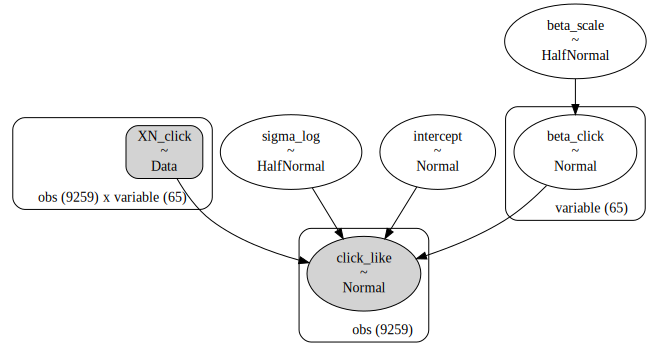

In [49]:
model4.to_graphviz()

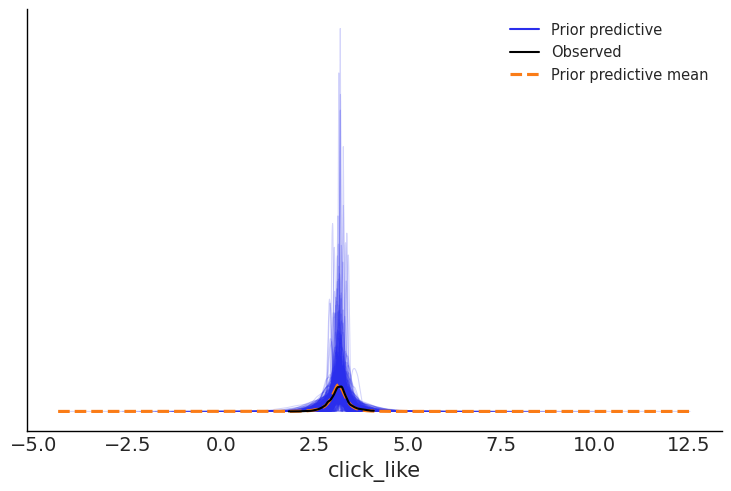

In [28]:
az.plot_ppc(prior4, group="prior", observed=True)
plt.show()

In [29]:
with model4:
    trace4 = pm.sample()
    trace4.extend(prior4)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta_scale, beta_click, sigma_log]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


In [268]:
summary_df = pm.summary(trace4, var_names=['beta_click'], coords={'variable': ['test']}).sort_values('ess_bulk')
print(summary_df)


                   mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta_click[test]  0.014  0.006   0.002    0.025        0.0      0.0    7134.0   

                  ess_tail  r_hat  
beta_click[test]    2911.0    1.0  


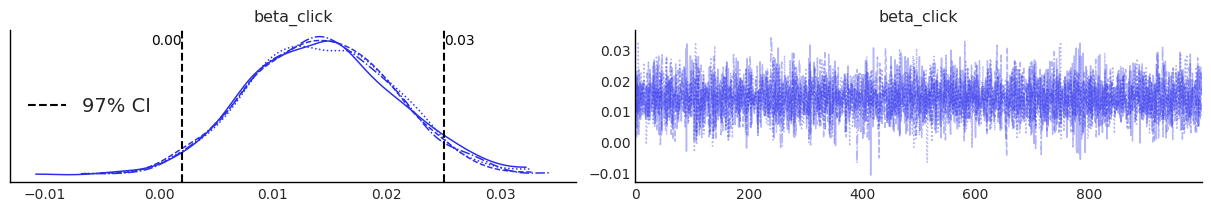

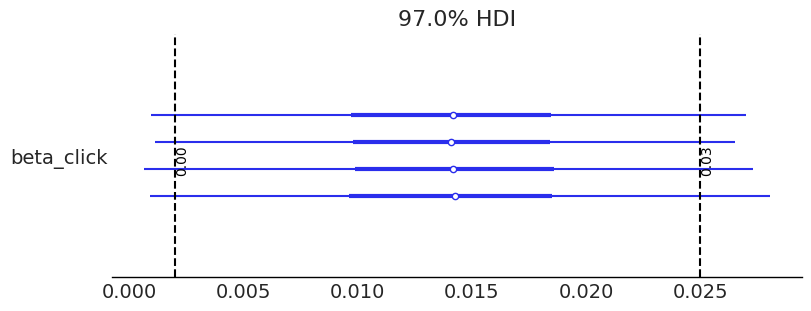

In [51]:
summary = az.summary(trace4, var_names=['beta_click'], coords={'variable': ['test']})
ci_lower = summary.loc["beta_click[test]", "hdi_3%"]
ci_upper = summary.loc["beta_click[test]", "hdi_97%"]

axes = az.plot_trace(trace4, var_names=['beta_click'], coords={'variable': ['test']})

dist_ax, trace_ax = axes[0] 

dist_ax.axvline(ci_lower, color="black", linestyle="--", label="97% CI")
dist_ax.axvline(ci_upper, color="black", linestyle="--")
y_min, y_max = dist_ax.get_ylim()
dist_ax.text(ci_lower, y_max * 0.9, f"{ci_lower:.2f}", color="black", ha="right")
dist_ax.text(ci_upper, y_max * 0.9, f"{ci_upper:.2f}", color="black", ha="left")
dist_ax.legend()

plt.show()

fig, ax = plt.subplots(figsize=(8, 3))
az.plot_forest(trace4, var_names=['beta_click'], coords={'variable': ['test']}, combined=False, ax=ax, hdi_prob=0.97)

ax.axvline(ci_lower, color="black", linestyle="--")
ax.axvline(ci_upper, color="black", linestyle="--")
ax.text(ci_lower, 0.2, f"{ci_lower:.2f}", color="black", rotation=90, verticalalignment="center")
ax.text(ci_upper, 0.2, f"{ci_upper:.2f}", color="black", rotation=90, verticalalignment="center")

plt.show()

### Сравним модели

In [ ]:
with model:
    trace_compare = pm.sample(return_inferencedata=True, idata_kwargs={"log_likelihood": True})

with model2:
    trace2_compare = pm.sample(return_inferencedata=True, idata_kwargs={"log_likelihood": True})

with model3:
    trace3_compare = pm.sample(return_inferencedata=True, idata_kwargs={"log_likelihood": True})

In [ ]:
res = az.compare(dict(hierarchy_late=trace_compare, r2d2_late=trace2_compare, r2d2_late_parcels=trace3_compare))

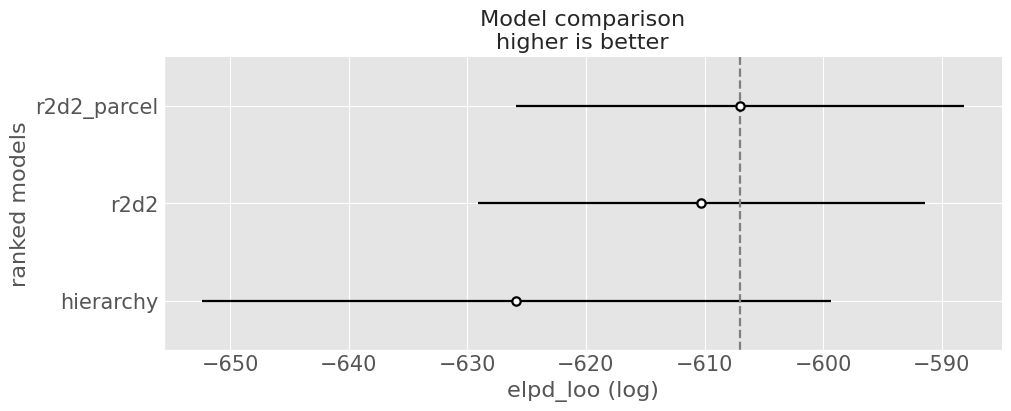

In [ ]:
az.plot_compare(res, figsize=(10, 4));

### Финальные результаты

In [52]:
test = df[df['test'] == 1][['late', 'parcels_quantity']].sum()['late'] / df[df['test'] == 1][['late', 'parcels_quantity']].sum()['parcels_quantity'] 
control = df[df['test'] == 0][['late', 'parcels_quantity']].sum()['late'] / df[df['test'] == 0][['late', 'parcels_quantity']].sum()['parcels_quantity']

uplift = (test - control) / control * 100
print(f'Настоящий uplift в данных: {uplift:.2f}%')

###################################################################################################################################################################

alpha_samples = trace.posterior['alpha'].values.flatten()
beta_test_samples = trace.posterior['beta_test'].values.flatten()

mu_test_0 = alpha_samples
mu_test_1 = alpha_samples + beta_test_samples

p_test_0 = 1 / (1 + np.exp(-mu_test_0))
p_test_1 = 1 / (1 + np.exp(-mu_test_1))

uplift_percent = ((p_test_1.mean() - p_test_0.mean()) / p_test_0.mean()) * 100

print(f"Средний uplift на иерархической линейной модели: {uplift_percent:.2f}%")

###################################################################################################################################################################
XN_test_0 = data_array.copy()
XN_test_1 = data_array.copy()

index_of_test_var = coords['variable'].index('test')
XN_test_0[:, index_of_test_var] = 0
XN_test_1[:, index_of_test_var] = 1

beta_samples = trace2.posterior['beta'].sel(variable='test').values.flatten()

mu_diff = beta_samples
uplift_percent = (np.exp(mu_diff).mean() - 1) * 100

print(f"Средний uplift основанный на R2D2 модели: {uplift_percent:.2f}%")

###################################################################################################################################################################
XN_test_0 = data_array.copy()
XN_test_1 = data_array.copy()

index_of_test_var = coords['variable'].index('test')
XN_test_0[:, index_of_test_var] = 0
XN_test_1[:, index_of_test_var] = 1

beta_samples = trace3.posterior['beta'].sel(variable='test').values.flatten()

mu_diff = beta_samples
uplift_percent = (np.exp(mu_diff).mean() - 1) * 100

print(f"Средний uplift основанный на R2D2 модели c учетом заказов: {uplift_percent:.2f}%")

###################################################################################################################################################################

beta_test_samples = trace4.posterior["beta_click"].sel(variable="test").values.flatten()

uplift_dist = np.exp(beta_test_samples) - 1

uplift_mean_percent = uplift_dist.mean() * 100

uplift_hdi = az.hdi(uplift_dist, hdi_prob=0.94)

print(f"Средний uplift по click-to-eat: {uplift_mean_percent:.2f}%")
print(f"94% HDI: [{uplift_hdi[0]*100:.2f}%, {uplift_hdi[1]*100:.2f}%]")

Настоящий uplift в данных: 24.26%
Средний uplift на иерархической линейной модели: 17.29%
Средний uplift основанный на R2D2 модели: 18.61%
Средний uplift основанный на R2D2 модели c учетом заказов: 12.73%
Средний uplift по click-to-eat: 1.43%
94% HDI: [0.16%, 2.56%]
